In [57]:
import os
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.models as models

import wandb

### Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


In [3]:
saved_model_folder = "./saved_models"
os.makedirs(saved_model_folder, exist_ok=True)

### Data Loading and Processing

In [4]:
def build_people_dict(csv_path, root_dir):
    """
    This function takes the CSV file and creates a dictionary of file paths corresponding to each person in the CSV file.
    """
    df = pd.read_csv(csv_path)
    people_dict = defaultdict(list)
    
    for idx, row in df.iterrows():
        person_name = row['name']
        num_images_expected = row['images']
        
        # Get full folder path
        person_folder = os.path.join(root_dir, person_name)
        
        file_extensions = ('.jpg', '.jpeg', '.png')
        if os.path.exists(person_folder):
            image_files = []
            for file in os.listdir(person_folder):
                if file.endswith(file_extensions):
                    image_files.append(file)
                image_files = sorted(image_files)
    
                # Build the full paths for the images
                full_paths = [os.path.join(person_folder, img_file) for img_file in image_files]
                
                people_dict[person_name].extend(full_paths)
        else:
            print(f"No folder found for person: {person_name}")
    
    return dict(people_dict)

In [5]:
train_csv = "/home/user/javeda1/lwf_dataset/peopleDevTrain.csv"
test_csv = "/home/user/javeda1/lwf_dataset/peopleDevTest.csv"
root_dir = "/home/user/javeda1/lwf_datasets"  # Folder containing image subfolders

people_dict_train = build_people_dict(train_csv, root_dir)
people_dict_test = build_people_dict(test_csv, root_dir)

In [6]:
class LFWDataset(Dataset):
    def __init__(self, people_dict, transform=None, num_samples=10000):
        self.people_dict = people_dict
        self.person_ids = list(people_dict.keys())
        self.transform = transform
        self.num_samples = num_samples
        
        self.label2id = {person: idx for idx, person in enumerate(self.person_ids)}

    def __len__(self):
        return len(self.people_dict)

    def __getitem__(self, idx):
        # Sample a random person for the anchor
        anchor_person = random.choice(self.person_ids)
        
        # Get positive and negative anchors
        if len(self.people_dict[anchor_person]) < 2:
            # Recursively call the function until an anchor person with >= 2 images is found
            return self.__getitem__(random.randint(0, self.num_samples - 1))
        
        anchor_path, positive_path = random.sample(self.people_dict[anchor_person], 2)
        
        negative_person = random.choice(self.person_ids)
        # Again while loop till a different person is found.
        while negative_person == anchor_person or len(self.people_dict[negative_person]) < 1:
            negative_person = random.choice(self.person_ids)
        negative_path = random.choice(self.people_dict[negative_person])
        
        anchor_img = Image.open(anchor_path).convert("RGB")
        positive_img = Image.open(positive_path).convert("RGB")
        negative_img = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)


        anchor_label = self.label2id[anchor_person]
        positive_label = anchor_label
        negative_label = self.label2id[negative_person]

        return anchor_img, positive_img, negative_img, anchor_label, positive_label, negative_label

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

In [10]:
# Create the Datasets
train_dataset = LFWDataset(people_dict_train, transform=train_transform)
test_dataset = LFWDataset(people_dict_test, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

### Visualize Dataset

In [11]:
def minmax_normalize(tensor):
    # Min-max normalization
    tensor_min, tensor_max = tensor.min(), tensor.max()
    return (tensor - tensor_min) / (tensor_max - tensor_min)


def visualize_triplet_samples(dataset, n=5):
    """
    Visualize n samples from the TripletDataset using Min-Max normalization.
    """

    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(9, 3*n))

    for i in range(n):
        # Fetch one item
        anchor, positive, negative, _, _, _ = dataset[i]

        # Apply Min-Max normalization
        anchor_disp = minmax_normalize(anchor)
        positive_disp = minmax_normalize(positive)
        negative_disp = minmax_normalize(negative)

        anchor_np = anchor_disp.permute(1, 2, 0).cpu().numpy()
        positive_np = positive_disp.permute(1, 2, 0).cpu().numpy()
        negative_np = negative_disp.permute(1, 2, 0).cpu().numpy()

        axes[i, 0].imshow(anchor_np)
        axes[i, 1].imshow(positive_np)
        axes[i, 2].imshow(negative_np)
        
        axes[i, 0].set_title("Anchor")
        axes[i, 1].set_title("Positive")
        axes[i, 2].set_title("Negative")
        
        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

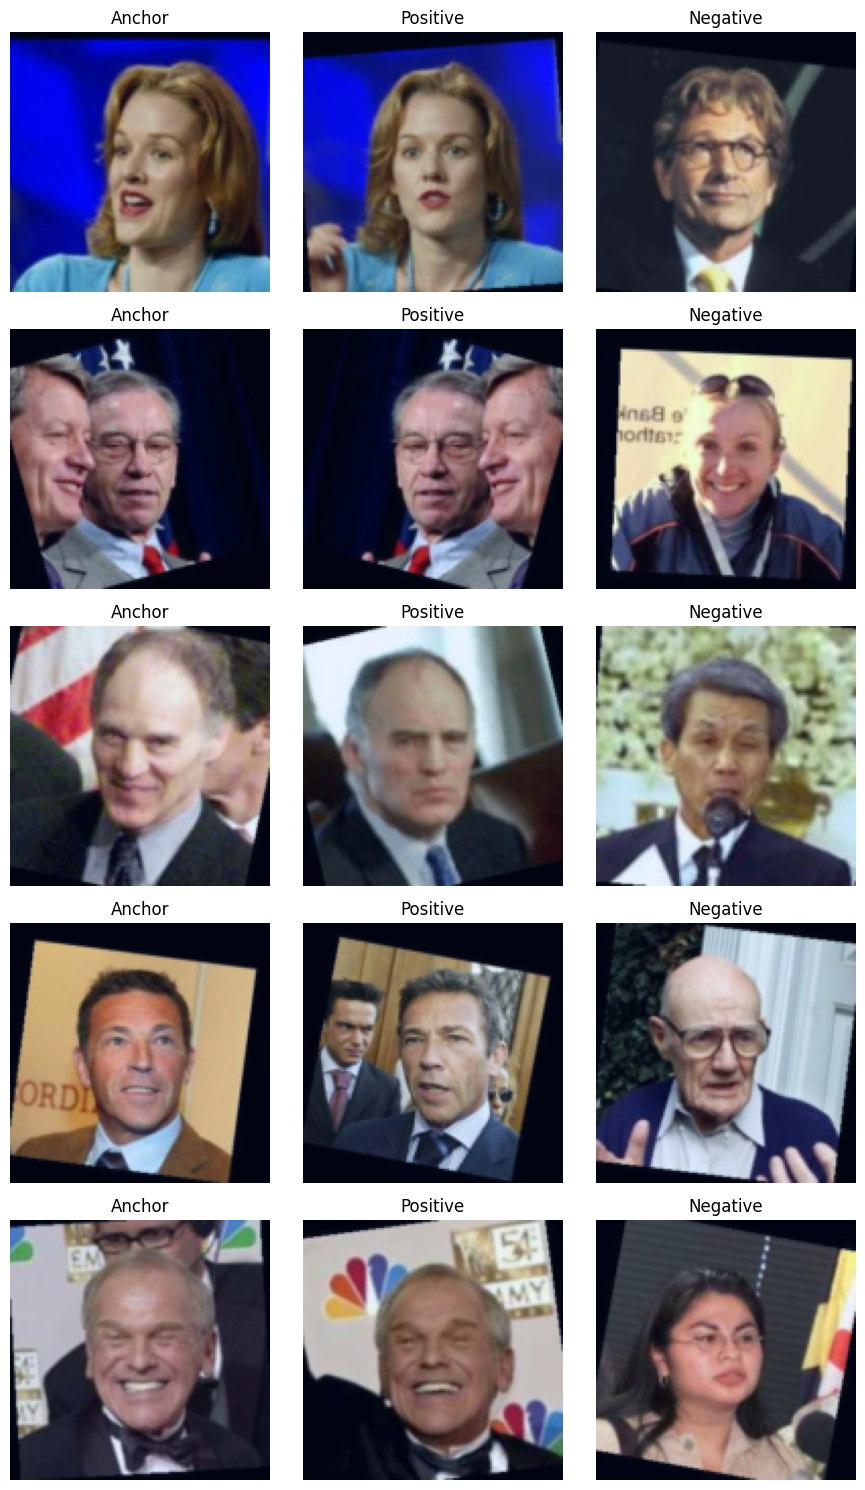

In [12]:
visualize_triplet_samples(train_dataset, n=5)

### Model architecture

In [13]:
class TriNet(nn.Module):
    def __init__(self, embedding_dim=128, pretrained=True):
        super(TriNet, self).__init__()
        #ResNet18
        self.resnet = models.resnet18(pretrained=pretrained)
        # Remove the last FC
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  
        
        self.fc = nn.Linear(512, embedding_dim)

    def forward(self, x):
        
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        
        return x

### Training Code

In [14]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    """Trains the model for one epoch """
    model.train()
    running_loss = 0.0
    
    for anchor, positive, negative, _, _,_ in dataloader:
        anchor   = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        # Forward pass
        anchor_emb   = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Calculate loss
        loss = loss_fn(anchor_emb, positive_emb, negative_emb)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * anchor.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def eval_one_epoch(model, dataloader, loss_fn, device):
    """Evaluates the model after each epoch."""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for anchor, positive, negative, _, _, _ in dataloader:
            anchor   = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_emb   = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)

            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            running_loss += loss.item() * anchor.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def train(model, train_dataloader, val_dataloader, optimizer,
          device, epochs=10, margin=0.5,
         project="my_trinet-project", name='test_run-1'):

    
    # Initialize W&B
    wandb.init(project=project, name=name, config={
        "epochs": epochs,
        "margin": margin,
        "learning_rate": optimizer.param_groups[0]["lr"]
    })

    # triplet loss
    triplet_loss_fn = nn.TripletMarginLoss(margin=margin, p=2)

    for epoch in tqdm(range(epochs)):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, triplet_loss_fn, device)
        val_loss   = eval_one_epoch(model, val_dataloader, triplet_loss_fn, device)
        
        #learning rate
        current_lr = optimizer.param_groups[0]["lr"]

        # Log metrics to wandb
        wandb.log({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "learning_rate": current_lr,
            "epoch": epoch + 1
        })

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

    # Finish wandb run
    wandb.finish()

    return model

### Load Model

In [15]:
def load_model(model_path):
    """
    Load a saved model
    """
    model = torch.load(model_path)
    return model

### Compute ARI for the trained models

In [66]:
def get_top_k_people(people_dict, k=10):
    """
    Returns a list of the k person_ids that have the most images.
    
    people_dict: dict { person_id : [list_of_image_paths] }
    k: number of classes to pick
    
    Returns:
      top_k_people: list of person_id strings
    """
    # Build a list of (num_images, person_id)
    counts = [(len(paths), person) for person, paths in people_dict.items()]
    
    # Sort descending by num_images or use nlargest
    # Option 1: sort
    counts.sort(reverse=True, key=lambda x: x[0])
    top_k_people = [person for (count, person) in counts[:k]]
    
    # Option 2: use heapq.nlargest
    # top_k = heapq.nlargest(k, counts, key=lambda x: x[0])
    # top_k_people = [person for (count, person) in top_k]
    
    return top_k_people

In [39]:
def gather_images_labels_topk(people_dict, top_k_people, transform=None):
    """
    Gathers (image_tensors, labels) for just the top_k_people.
    Returns:
      all_images: list of tensors
      all_labels: list of int labels
      label2id: dict person -> int index
    """
    # Build a label2id for just these top_k_people
    label2id = {person: idx for idx, person in enumerate(top_k_people)}
    
    all_images = []
    all_labels = []
    
    for person in top_k_people:
        paths = people_dict[person]
        label = label2id[person]
        for img_path in paths:
            img = Image.open(img_path).convert("RGB")
            if transform:
                img = transform(img)
            all_images.append(img)
            all_labels.append(label)
    
    return all_images, all_labels, label2id

In [46]:
def gather_images_and_labels(dataset, num_samples=1000):
    """
    Gathers ONLY the anchor images and labels from a triplet-based dataset.
    
    Args:
      dataset: returns (anchor_img, positive_img, negative_img, anchor_lbl, positive_lbl, negative_lbl)
      num_samples: how many times to sample the dataset (each time we pick 1 anchor)
    
    Returns:
      all_imgs: list of anchor image tensors
      all_labels: list of anchor labels
    """
    import random
    
    all_imgs = []
    all_labels = []
    
    # Shuffle and pick some indices
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    chosen_indices = indices[:num_samples]

    for idx in chosen_indices:
        anchor_img, positive_img, negative_img, anchor_lbl, positive_lbl, negative_lbl = dataset[idx]
        
        # Only store the anchor
        all_imgs.append(anchor_img)
        all_labels.append(anchor_lbl)

    return all_imgs, all_labels

In [47]:
def compute_embeddings(model, images, labels, device):
    """
    Compute embeddings for a list of image tensors (C,H,W).
    Returns:
      embeddings: np.array of shape (N, embedding_dim)
      labels: np.array of shape (N,)
    """
    model.eval()
    embeddings_list = []
    labels = np.array(labels)  # Convert to NumPy array (optional)

    with torch.no_grad():
        for img_tensor in images:
            # Unsqueeze to make shape (1, C, H, W) so the model sees a batch of size 1
            img_tensor = img_tensor.unsqueeze(0).to(device)
            emb = model(img_tensor)           # shape: (1, embedding_dim)
            embeddings_list.append(emb.cpu()) # store on CPU

    # Concatenate into a single NumPy array
    embeddings = torch.cat(embeddings_list, dim=0).numpy()  # shape: (N, embedding_dim)

    return embeddings, labels

In [81]:
def compute_ari_from_embeddings(embeddings, labels, device):
    """
    Compute's ARI from the embeddings
    """

    # embeddings, labels = compute_embeddings(model, images, labels, device)

    # K-Means
    all_labels = np.array(labels)
    unique_labels = np.unique(all_labels)
    n_clusters = len(unique_labels)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_assignments = kmeans.fit_predict(embeddings)

    # ARI
    ari = adjusted_rand_score(all_labels, cluster_assignments)
    return ari

In [49]:
def visualize_embeddings_2D(embeddings, labels, method="pca"):
    """
    Reduce 'embeddings' (N, D) to 2D and visualize with a scatter plot,
    coloring points by 'labels'.
    
    method: "pca" or "tsne"
    """
    if method == "pca":
        reducer = PCA(n_components=2)
        reduced = reducer.fit_transform(embeddings)
        title = "PCA"
    elif method == "tsne":
        reducer = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
        reduced = reducer.fit_transform(embeddings)
        title = "t-SNE"
    else:
        raise ValueError("method must be 'pca' or 'tsne'")
    
    # Plot
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    
    for lab in unique_labels:
        idx = (labels == lab)
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f"Class {lab}", alpha=0.7)
    
    plt.legend(loc="best")
    plt.title(f"2D Embeddings via {title}")
    plt.show()

In [76]:
def visualize_embeddings_2D(embeddings, labels, id2label=None, method="pca"):
    """
    Reduce 'embeddings' (N, D) to 2D and visualize with a scatter plot,
    coloring points by 'labels'. If 'id2label' is provided, we use it 
    to convert numeric labels to string names in the legend.

    Args:
      embeddings: (N, embedding_dim) NumPy array
      labels: (N,) NumPy array of integer labels
      id2label: dict mapping label_id (int) -> person_name (str). 
                If None, we just show numeric labels.
      method: "pca" or "tsne"
    """
    if method == "pca":
        reducer = PCA(n_components=2)
        reduced = reducer.fit_transform(embeddings)
        title = "PCA"
    elif method == "tsne":
        reducer = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
        reduced = reducer.fit_transform(embeddings)
        title = "t-SNE"
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    plt.figure(figsize=(12, 16))
    unique_labels = np.unique(labels)
    
    # Plot each label group in a different color
    for lab in unique_labels:
        idx = (labels == lab)
        # If we have an id2label mapping, use the string name; else just "Class {lab}"
        legend_label = id2label[lab] if id2label is not None else f"Class {lab}"
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=legend_label, alpha=0.7)
    
    plt.legend(loc="best")
    plt.title(f"2D Embeddings via {title}")
    plt.show()

### Model Training

In [79]:
# Paramters
margin=0.2
epochs=40
project='trinet_model'
name='test_run2'
# name=f"margin_{margin}_ep_{epochs}"

model = TriNet(embedding_dim=128).to(device)

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train model
model = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    margin=margin,
    name=name,
    project=project
)

/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/javeda1/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  2%|█▍                                                      | 1/40 [00:21<14:06, 21.71s/it]

Epoch [1/40] Train Loss: 0.0497 | Val Loss: 0.0456 | LR: 0.000100


  5%|██▊                                                     | 2/40 [00:43<13:36, 21.48s/it]

Epoch [2/40] Train Loss: 0.0235 | Val Loss: 0.0351 | LR: 0.000100


  8%|████▏                                                   | 3/40 [01:03<12:58, 21.05s/it]

Epoch [3/40] Train Loss: 0.0179 | Val Loss: 0.0351 | LR: 0.000100


 10%|█████▌                                                  | 4/40 [01:24<12:40, 21.13s/it]

Epoch [4/40] Train Loss: 0.0153 | Val Loss: 0.0310 | LR: 0.000100


 12%|███████                                                 | 5/40 [01:45<12:12, 20.93s/it]

Epoch [5/40] Train Loss: 0.0133 | Val Loss: 0.0277 | LR: 0.000100


 15%|████████▍                                               | 6/40 [02:05<11:46, 20.77s/it]

Epoch [6/40] Train Loss: 0.0116 | Val Loss: 0.0296 | LR: 0.000100


 18%|█████████▊                                              | 7/40 [02:29<11:53, 21.63s/it]

Epoch [7/40] Train Loss: 0.0125 | Val Loss: 0.0230 | LR: 0.000100


 20%|███████████▏                                            | 8/40 [02:50<11:23, 21.37s/it]

Epoch [8/40] Train Loss: 0.0111 | Val Loss: 0.0256 | LR: 0.000100


 22%|████████████▌                                           | 9/40 [03:10<10:55, 21.13s/it]

Epoch [9/40] Train Loss: 0.0099 | Val Loss: 0.0254 | LR: 0.000100


 25%|█████████████▊                                         | 10/40 [03:31<10:29, 20.97s/it]

Epoch [10/40] Train Loss: 0.0094 | Val Loss: 0.0215 | LR: 0.000100


 28%|███████████████▏                                       | 11/40 [03:51<10:03, 20.81s/it]

Epoch [11/40] Train Loss: 0.0108 | Val Loss: 0.0236 | LR: 0.000100


 30%|████████████████▌                                      | 12/40 [04:11<09:37, 20.64s/it]

Epoch [12/40] Train Loss: 0.0087 | Val Loss: 0.0224 | LR: 0.000100


 32%|█████████████████▉                                     | 13/40 [04:32<09:15, 20.56s/it]

Epoch [13/40] Train Loss: 0.0084 | Val Loss: 0.0231 | LR: 0.000100


 35%|███████████████████▎                                   | 14/40 [04:52<08:50, 20.41s/it]

Epoch [14/40] Train Loss: 0.0065 | Val Loss: 0.0250 | LR: 0.000100


 38%|████████████████████▋                                  | 15/40 [05:12<08:28, 20.35s/it]

Epoch [15/40] Train Loss: 0.0062 | Val Loss: 0.0243 | LR: 0.000100


 40%|██████████████████████                                 | 16/40 [05:32<08:07, 20.29s/it]

Epoch [16/40] Train Loss: 0.0088 | Val Loss: 0.0221 | LR: 0.000100


 42%|███████████████████████▍                               | 17/40 [05:52<07:46, 20.27s/it]

Epoch [17/40] Train Loss: 0.0076 | Val Loss: 0.0223 | LR: 0.000100


 45%|████████████████████████▊                              | 18/40 [06:13<07:25, 20.27s/it]

Epoch [18/40] Train Loss: 0.0064 | Val Loss: 0.0249 | LR: 0.000100


 48%|██████████████████████████▏                            | 19/40 [06:33<07:05, 20.26s/it]

Epoch [19/40] Train Loss: 0.0073 | Val Loss: 0.0234 | LR: 0.000100


 50%|███████████████████████████▌                           | 20/40 [06:53<06:45, 20.25s/it]

Epoch [20/40] Train Loss: 0.0069 | Val Loss: 0.0212 | LR: 0.000100


 52%|████████████████████████████▉                          | 21/40 [07:14<06:25, 20.30s/it]

Epoch [21/40] Train Loss: 0.0064 | Val Loss: 0.0214 | LR: 0.000100


 55%|██████████████████████████████▎                        | 22/40 [07:34<06:05, 20.30s/it]

Epoch [22/40] Train Loss: 0.0067 | Val Loss: 0.0220 | LR: 0.000100


 57%|███████████████████████████████▌                       | 23/40 [07:54<05:45, 20.33s/it]

Epoch [23/40] Train Loss: 0.0059 | Val Loss: 0.0226 | LR: 0.000100


 60%|█████████████████████████████████                      | 24/40 [08:14<05:23, 20.25s/it]

Epoch [24/40] Train Loss: 0.0056 | Val Loss: 0.0213 | LR: 0.000100


 62%|██████████████████████████████████▍                    | 25/40 [08:35<05:03, 20.23s/it]

Epoch [25/40] Train Loss: 0.0066 | Val Loss: 0.0236 | LR: 0.000100


 65%|███████████████████████████████████▊                   | 26/40 [08:55<04:42, 20.18s/it]

Epoch [26/40] Train Loss: 0.0058 | Val Loss: 0.0190 | LR: 0.000100


 68%|█████████████████████████████████████▏                 | 27/40 [09:15<04:22, 20.18s/it]

Epoch [27/40] Train Loss: 0.0051 | Val Loss: 0.0187 | LR: 0.000100


 70%|██████████████████████████████████████▌                | 28/40 [09:35<04:01, 20.13s/it]

Epoch [28/40] Train Loss: 0.0058 | Val Loss: 0.0217 | LR: 0.000100


 72%|███████████████████████████████████████▉               | 29/40 [09:55<03:41, 20.16s/it]

Epoch [29/40] Train Loss: 0.0066 | Val Loss: 0.0206 | LR: 0.000100


 75%|█████████████████████████████████████████▎             | 30/40 [10:15<03:21, 20.13s/it]

Epoch [30/40] Train Loss: 0.0064 | Val Loss: 0.0243 | LR: 0.000100


 78%|██████████████████████████████████████████▋            | 31/40 [10:35<03:00, 20.10s/it]

Epoch [31/40] Train Loss: 0.0068 | Val Loss: 0.0229 | LR: 0.000100


 80%|████████████████████████████████████████████           | 32/40 [10:55<02:40, 20.11s/it]

Epoch [32/40] Train Loss: 0.0054 | Val Loss: 0.0221 | LR: 0.000100


 82%|█████████████████████████████████████████████▍         | 33/40 [11:15<02:20, 20.09s/it]

Epoch [33/40] Train Loss: 0.0057 | Val Loss: 0.0199 | LR: 0.000100


 85%|██████████████████████████████████████████████▊        | 34/40 [11:35<02:00, 20.06s/it]

Epoch [34/40] Train Loss: 0.0054 | Val Loss: 0.0237 | LR: 0.000100


 88%|████████████████████████████████████████████████▏      | 35/40 [11:55<01:40, 20.08s/it]

Epoch [35/40] Train Loss: 0.0053 | Val Loss: 0.0203 | LR: 0.000100


 90%|█████████████████████████████████████████████████▌     | 36/40 [12:16<01:20, 20.08s/it]

Epoch [36/40] Train Loss: 0.0058 | Val Loss: 0.0224 | LR: 0.000100


 92%|██████████████████████████████████████████████████▉    | 37/40 [12:36<01:00, 20.06s/it]

Epoch [37/40] Train Loss: 0.0055 | Val Loss: 0.0188 | LR: 0.000100


 95%|████████████████████████████████████████████████████▎  | 38/40 [12:56<00:40, 20.06s/it]

Epoch [38/40] Train Loss: 0.0052 | Val Loss: 0.0230 | LR: 0.000100


 98%|█████████████████████████████████████████████████████▋ | 39/40 [13:16<00:20, 20.08s/it]

Epoch [39/40] Train Loss: 0.0054 | Val Loss: 0.0215 | LR: 0.000100


100%|███████████████████████████████████████████████████████| 40/40 [13:36<00:00, 20.41s/it]

Epoch [40/40] Train Loss: 0.0055 | Val Loss: 0.0152 | LR: 0.000100


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▄▃▃▃▂▃▃▃▃▃▃▃▃▃▂▂▃▃▂▃▂▂▂▂▃▃▃▂▃▂▃▂▃▂▁
epoch,40
learning_rate,0.0001
train_loss,0.00546
val_loss,0.01524


In [80]:
all_imgs, all_labels = gather_images_and_labels(dataset=test_dataset, num_samples=5000)
# ari_value = compute_ari_from_embeddings(
#     images=all_imgs,
#     labels=all_labels,
#     device=device
# )

# print(f"Adjusted Rand Index (ARI): {ari_value:.4f}")

1711


TypeError: compute_ari_from_embeddings() got an unexpected keyword argument 'model'

In [82]:
embeddings, labels = compute_embeddings(model, all_imgs, all_labels, device)
compute_ari_from_embeddings(embeddings, labels, device)

0.4709125641860933

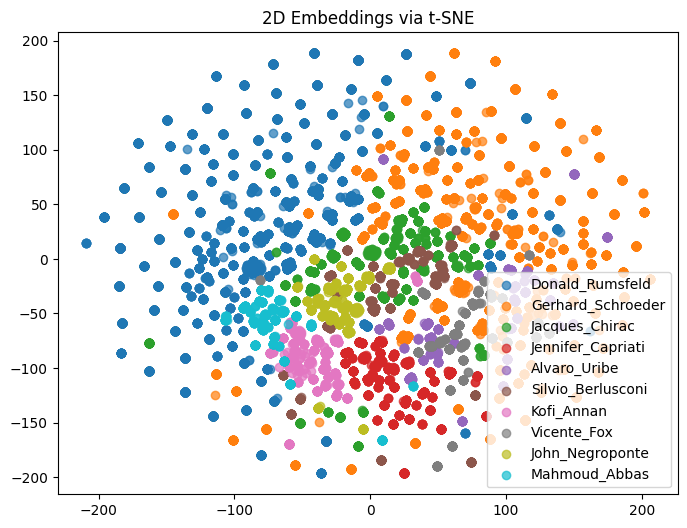

In [73]:
top_k_people = get_top_k_people(people_dict_test, k=10)
all_imgs, all_labels, label2id = gather_images_labels_topk(
        people_dict_test, top_k_people, transform=test_transform
    )
id2label = {i: person for person, i in label2id.items()}
embeddings, labels = compute_embeddings(model, all_imgs, all_labels, device)
visualize_embeddings_2D(embeddings, labels, method="tsne", id2label=id2label)

In [68]:
top_k_people

['Donald_Rumsfeld',
 'Gerhard_Schroeder',
 'Jacques_Chirac',
 'Jennifer_Capriati',
 'Alvaro_Uribe',
 'Silvio_Berlusconi',
 'Kofi_Annan',
 'Vicente_Fox',
 'John_Negroponte',
 'Mahmoud_Abbas']

In [69]:
id2label = {i: person for person, i in label2id.items()}

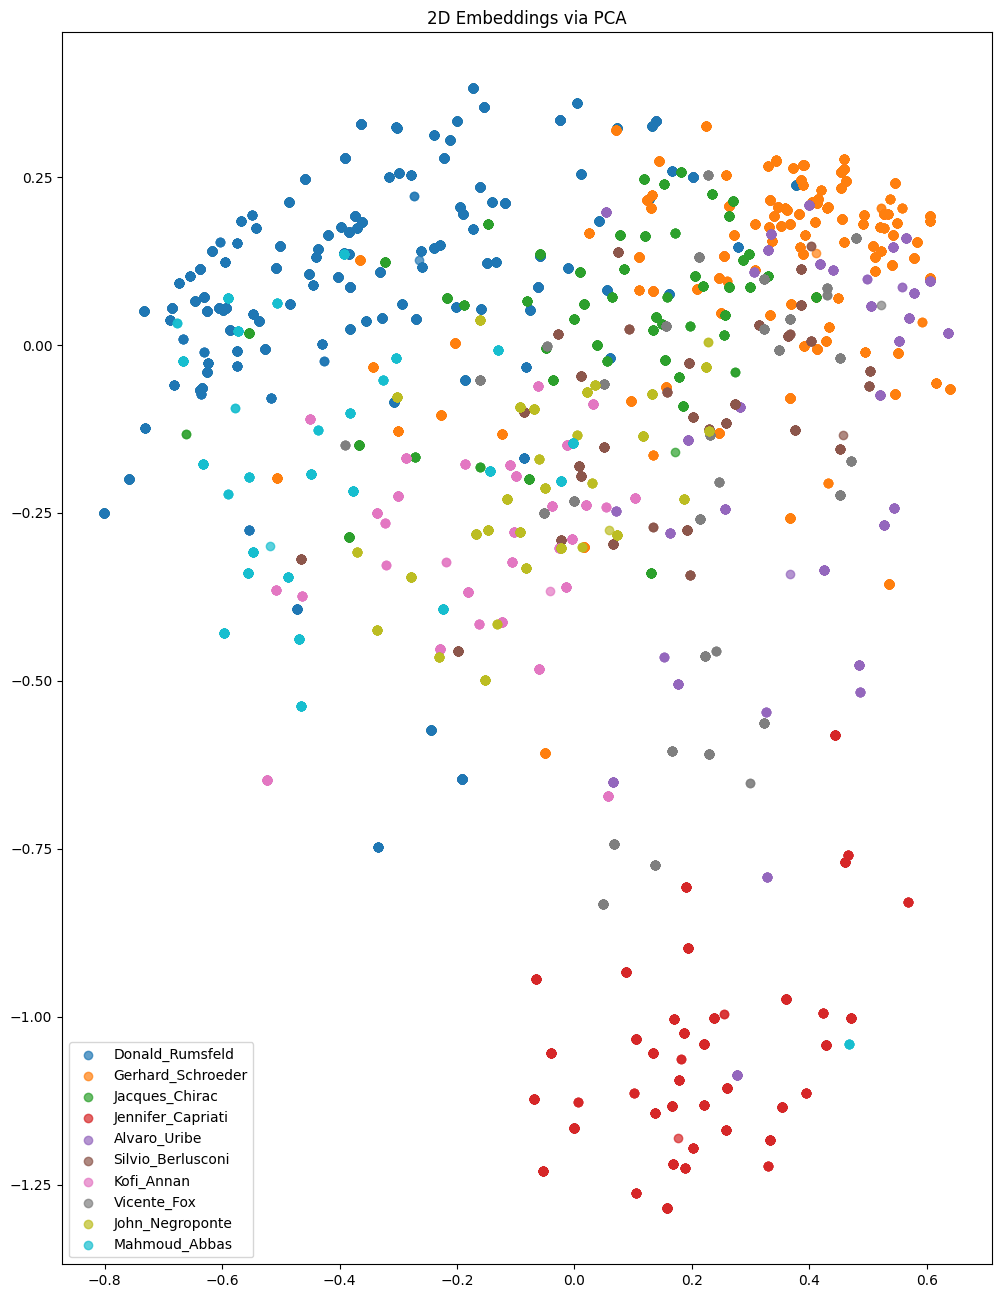

In [78]:
visualize_embeddings_2D(embeddings, labels, method="pca", id2label=id2label)